If you want to run this colab please follow the instructions below

1. Download and upload the data from https://drive.google.com/drive/u/1/folders/1TcE9NNShm0irVqZM7y4Xtz7ibjHF9tAo to the colab (Data science project 2020/Data science project1/PM2.5_kaggle_2021)

2. Unzip the uploaded folder by typing the zip file name in cell 1 and rename foler after unzip to 'PM2.5_kaggle_2021'

3. Edit path in cell 3 to '/content/PM2.5_kaggle_2021'

In [ ]:
pd.read_csv(os.path.join(path, 'Bangkok', 'bkk_test.csv')).tail(5)

,datetime,PM2.5,day_of_year,day_of_week,Temp,lat,long,WindDir,Wind Speed(km/h),hotspot_count_Thailand,hotspot_count_Cambodia,hotspot_count_Lao_PDR,hotspot_count_Myanmar,PM2.5_lastyear
8792,2020-03-18 16:00:00,23.9,78,2,33.000000,13.754,100.5014,210.000000,7.000000,0.0,0.0,0.0,0.0,32.7
8793,2020-03-18 17:00:00,24.4,78,2,32.133333,13.754,100.5014,226.666667,6.666667,0.0,0.0,0.0,0.0,29.4
8794,2020-03-18 18:00:00,24.9,78,2,31.266667,13.754,100.5014,243.333333,6.333333,0.0,0.0,0.0,0.0,32.6
8795,2020-03-18 19:00:00,27.0,78,2,30.400000,13.754,100.5014,260.000000,6.000000,0.0,0.0,0.0,0.0,34.5
8796,2020-03-18 20:00:00,26.1,78,2,29.966667,13.754,100.5014,230.000000,6.666667,0.0,0.0,0.0,0.0,33.0


In [ ]:
# !unzip

In [ ]:
import os
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import math
import datetime
from math import pi

In [ ]:
path = '/content/drive/Shareddrives/Data science project/PM2.5_kaggle_2021'

In [ ]:
def load_data(df, n_in=1, n_out=72, features=['PM2.5']):
    n_features = len(features)
    data = df[features].to_numpy()
    X = []
    y = []
    for i in range(len(data)-n_in-n_out):
        X.append(data[i: i+n_in+2])
        temp = []
        for j in range(i+n_in+1, i+n_in+1 + n_out):
            temp.append(data[j][0])
        y.append(temp)
    X = np.array(X)
    y = np.array(y)
    X = X[:, :-1]
    return X, y

def load_data_test(df, df_train, n_in=1, n_out=72, features=['PM2.5']):
    df_all = df_train.append(df)
    X, y = load_data(df_all, n_in, n_out, features=features)
    X, y = X[df_train.shape[0]-n_in+4::6], y[df_train.shape[0]-n_in+4::6]
    return X, y

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

def normalize(df_train, df_test):
    scaler_dict = dict()
    for col in [col for col in df_train.columns if col != 'PM2.5' and col != 'PM2.5_lastyear']:
        scaler = MinMaxScaler()
        df_train[col] = scaler.fit_transform(df_train[col].values.reshape(-1,1))
        scaler_dict[col] = scaler
    
    for col in [col for col in df_test.columns if col != 'PM2.5' and col != 'PM2.5_lastyear']:
        df_test[col] = scaler_dict[col].transform(df_test[col].values.reshape(-1,1))
      
    scaler = MinMaxScaler()
    df_train['PM2.5'] = scaler.fit_transform(df_train[['PM2.5']])
    df_train['PM2.5_lastyear'] = scaler.transform(df_train[['PM2.5_lastyear']])
    df_test['PM2.5'] = scaler.transform(df_test[['PM2.5']])
    df_test['PM2.5_lastyear'] = scaler.transform(df_test[['PM2.5_lastyear']])
    return df_train, df_test, scaler

In [ ]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import GRU
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.metrics import mean_squared_error
from matplotlib.pyplot import figure

In [ ]:
root_mean_square_error = dict()

In [ ]:
def rmse_(y_test, y_pred):
    sum = 0
    n = 0
    for i in range(len(y_test)):
        for j in range(len(y_test[i])):
            if (y_test[i][j] != 0):
                sum += (y_test[i][j]-y_pred[i][j])**2
                n += 1
    return (sum/n)**0.5

# Bangkok

## Data preparation

In [ ]:
bkk_train = pd.read_csv(os.path.join(path, 'Bangkok', 'bkk_train.csv'))
bkk_train.reset_index()
bkk_train['datetime'] = pd.to_datetime(bkk_train['datetime'])
bkk_train.set_index('datetime')

bkk_test = pd.read_csv(os.path.join(path, 'Bangkok', 'bkk_test.csv'))
bkk_test.reset_index()
bkk_test['datetime'] = pd.to_datetime(bkk_test['datetime'])
bkk_test.set_index('datetime')

bkk_train, bkk_test, scaler = normalize(bkk_train, bkk_test)

In [ ]:
features = ['PM2.5', 'PM2.5_lastyear', 'day_of_year', 'Temp', 'hotspot_count_Thailand', 
            'Wind Speed(km/h)', 'WindDir']

prev_hour = 36
n_features = len(features)

bkk_X_test, bkk_y_test = load_data_test(bkk_test, bkk_train, n_in=prev_hour, features=features)

## Load model

In [ ]:
from keras.models import load_model

In [ ]:
filepath = os.path.join(path, 'model3/Bangkok_best_model.hdf5')

bkk_model = load_model(filepath)

## Predict

In [ ]:
bkk_predict = bkk_model.predict(bkk_X_test)

In [ ]:
bkk_predict = scaler.inverse_transform(bkk_predict)
bkk_y_test = scaler.inverse_transform(bkk_y_test)

In [ ]:
root_mean_square_error['Bangkok'] = rmse_(bkk_y_test, bkk_predict)
root_mean_square_error['Bangkok']

9.884646623842908

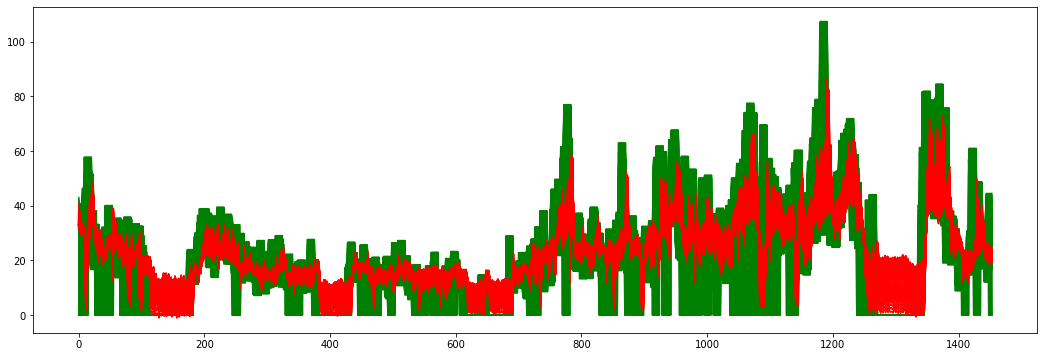

In [ ]:
plt.figure(figsize=(18,6))
plt.plot(bkk_y_test, color='g')
plt.plot(bkk_predict, color='r')
plt.show()

# Chanthaburi

## Data preparation

In [ ]:
cti_train = pd.read_csv(os.path.join(path, 'Chanthaburi', 'cti_train.csv'))
cti_train.reset_index()
cti_train['datetime'] = pd.to_datetime(cti_train['datetime'])
cti_train.set_index('datetime')

cti_test = pd.read_csv(os.path.join(path, 'Chanthaburi', 'cti_test.csv'))
cti_test.reset_index()
cti_test['datetime'] = pd.to_datetime(cti_test['datetime'])
cti_test.set_index('datetime')

cti_train, cti_test, scaler = normalize(cti_train, cti_test)

In [ ]:
features = ['PM2.5', 'PM2.5_lastyear', 'day_of_year', 'Temp', 'hotspot_count_Thailand', 
            'hotspot_count_Cambodia', 'Wind Speed(km/h)', 'WindDir']

prev_hour = 12
n_features = len(features)

cti_X_test, cti_y_test = load_data_test(cti_test, cti_train, n_in=prev_hour, features=features)

## Load model

In [ ]:
filepath = os.path.join(path, 'model3/Chanthaburi_best_model.hdf5')

cti_model = load_model(filepath)

## Predict

In [ ]:
cti_predict = cti_model.predict(cti_X_test)

In [ ]:
cti_predict = scaler.inverse_transform(cti_predict)
cti_y_test = scaler.inverse_transform(cti_y_test)

In [ ]:
root_mean_square_error['Chanthaburi'] = rmse_(cti_y_test, cti_predict)
root_mean_square_error['Chanthaburi']

7.170019740015291

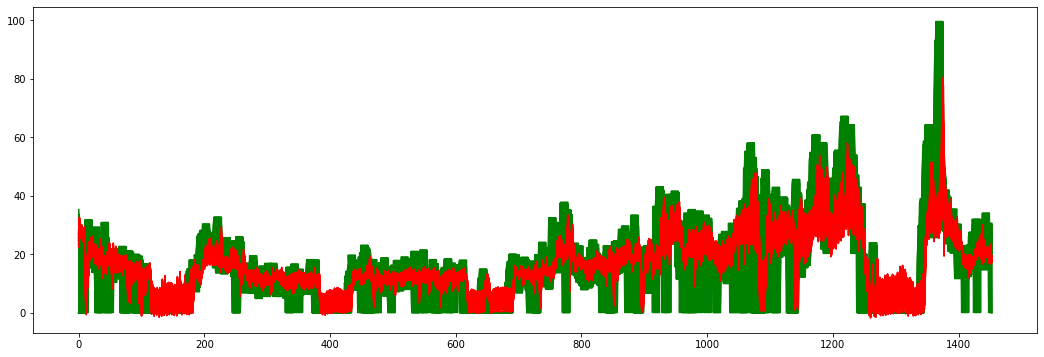

In [ ]:
plt.figure(figsize=(18,6))
plt.plot(cti_y_test, color='g')
plt.plot(cti_predict, color='r')
plt.show()

# Chiang Mai

## Data preparation

In [ ]:
cmi_train = pd.read_csv(os.path.join(path, 'Chiang Mai', 'cmi_train.csv'))
cmi_train.reset_index()
cmi_train['datetime'] = pd.to_datetime(cmi_train['datetime'])
cmi_train.set_index('datetime')

cmi_test = pd.read_csv(os.path.join(path, 'Chiang Mai', 'cmi_test.csv'))
cmi_test.reset_index()
cmi_test['datetime'] = pd.to_datetime(cmi_test['datetime'])
cmi_test.set_index('datetime')

cmi_train, cmi_test, scaler = normalize(cmi_train, cmi_test)

In [ ]:
features = ['PM2.5', 'day_of_year', 'PM2.5_lastyear', 'Temp', 'hotspot_count_Thailand', 
            'hotspot_count_Lao_PDR', 'hotspot_count_Myanmar', 'Wind Speed(km/h)', 'WindDir']
            
prev_hour = 36
n_features = len(features)

cmi_X_test, cmi_y_test = load_data_test(cmi_test, cmi_train, n_in=prev_hour, features=features)

## Load model

In [ ]:
filepath = os.path.join(path, 'model3/Chiang Mai_best_model.hdf5')

cmi_model = load_model(filepath)

## Predict

In [ ]:
cmi_predict = cmi_model.predict(cmi_X_test)

In [ ]:
cmi_predict = scaler.inverse_transform(cmi_predict)
cmi_y_test = scaler.inverse_transform(cmi_y_test)

In [ ]:
root_mean_square_error['Chiang Mai'] = rmse_(cmi_y_test, cmi_predict)
root_mean_square_error['Chiang Mai']

15.187432058028621

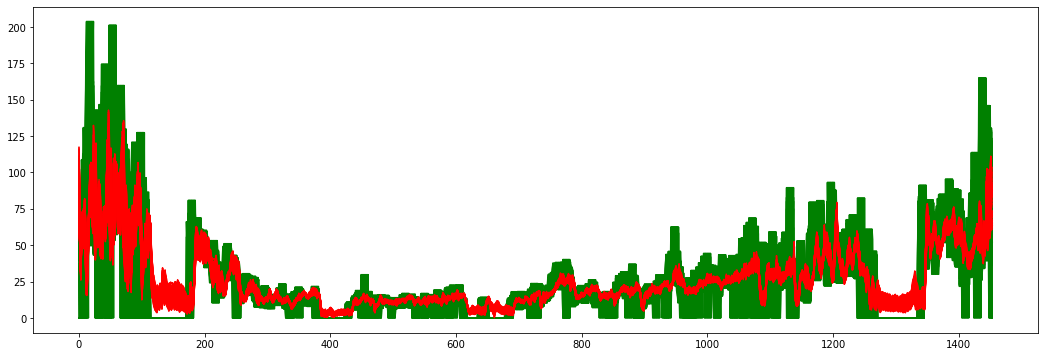

In [ ]:
plt.figure(figsize=(18,6))
plt.plot(cmi_y_test, color='g')
plt.plot(cmi_predict, color='r')
plt.show()

# Kanchanaburi

## Data preparation

In [ ]:
kri_train = pd.read_csv(os.path.join(path, 'Kanchanaburi', 'kri_train.csv'))
kri_train.reset_index()
kri_train['datetime'] = pd.to_datetime(kri_train['datetime'])
kri_train.set_index('datetime')

kri_test = pd.read_csv(os.path.join(path, 'Kanchanaburi', 'kri_test.csv'))
kri_test.reset_index()
kri_test['datetime'] = pd.to_datetime(kri_test['datetime'])
kri_test.set_index('datetime')

kri_train, kri_test, scaler = normalize(kri_train, kri_test)

In [ ]:
features = ['PM2.5', 'PM2.5_lastyear', 'day_of_year', 'Temp', 'hotspot_count_Thailand', 
            'Wind Speed(km/h)', 'WindDir']
            
prev_hour = 36
n_features = len(features)

kri_X_test, kri_y_test = load_data_test(kri_test, kri_train, n_in=prev_hour, features=features)

## Load model

In [ ]:
filepath = os.path.join(path, 'model3/Kanchanaburi_best_model.hdf5')

kri_model = load_model(filepath)

## Predict

In [ ]:
kri_predict = kri_model.predict(kri_X_test)

In [ ]:
kri_predict = scaler.inverse_transform(kri_predict)
kri_y_test = scaler.inverse_transform(kri_y_test)

In [ ]:
root_mean_square_error['Kanchanaburi'] = rmse_(kri_y_test, kri_predict)
root_mean_square_error['Kanchanaburi']

12.330461548231861

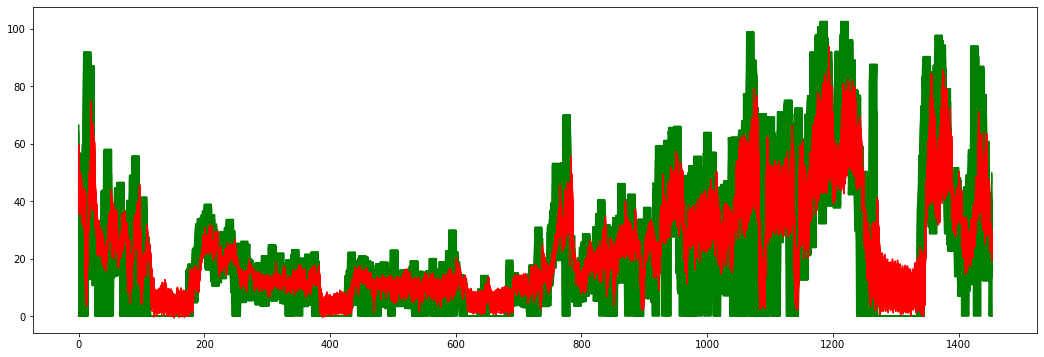

In [ ]:
plt.figure(figsize=(18,6))
plt.plot(kri_y_test, color='g')
plt.plot(kri_predict, color='r')
plt.show()

# Khon Kaen

## Data preparation

In [ ]:
kkn_train = pd.read_csv(os.path.join(path, 'Khon Kaen', 'kkn_train.csv'))
kkn_train.reset_index()
kkn_train['datetime'] = pd.to_datetime(kkn_train['datetime'])
kkn_train.set_index('datetime')

kkn_test = pd.read_csv(os.path.join(path, 'Khon Kaen', 'kkn_test.csv'))
kkn_test.reset_index()
kkn_test['datetime'] = pd.to_datetime(kkn_test['datetime'])
kkn_test.set_index('datetime')

kkn_train, kkn_test, scaler = normalize(kkn_train, kkn_test)

In [ ]:
features = ['PM2.5', 'PM2.5_lastyear', 'day_of_year', 'Temp', 'hotspot_count_Thailand', 
            'hotspot_count_Lao_PDR', 'Wind Speed(km/h)', 'WindDir']

prev_hour = 36
n_features = len(features)

kkn_X_test, kkn_y_test = load_data_test(kkn_test, kkn_train, n_in=prev_hour, features=features)

## Load model

In [ ]:
filepath = os.path.join(path, 'model3/Khon Kaen_best_model.hdf5')

kkn_model = load_model(filepath)

## Predict

In [ ]:
kkn_predict = kkn_model.predict(kkn_X_test)

In [ ]:
kkn_predict = scaler.inverse_transform(kkn_predict)
kkn_y_test = scaler.inverse_transform(kkn_y_test)

In [ ]:
root_mean_square_error['Khon Kaen'] = rmse_(kkn_y_test, kkn_predict)
root_mean_square_error['Khon Kaen']

12.314148536060873

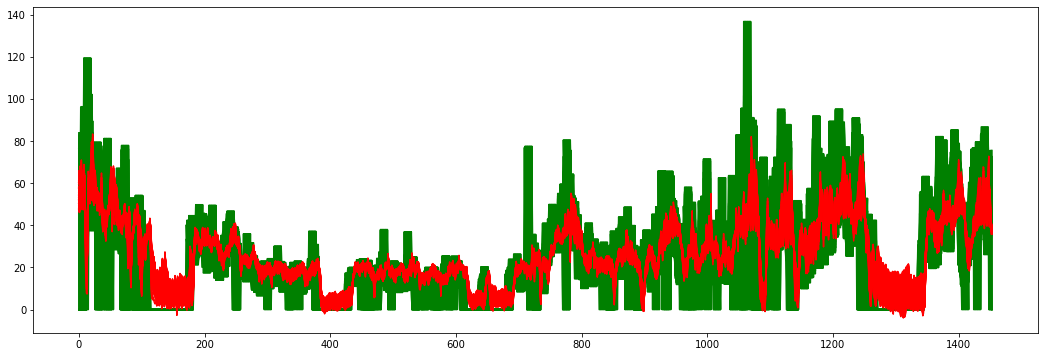

In [ ]:
plt.figure(figsize=(18,6))
plt.plot(kkn_y_test, color='g')
plt.plot(kkn_predict, color='r')
plt.show()

# Songkhla

## Data preparation

In [ ]:
ska_train = pd.read_csv(os.path.join(path, 'Songkhla', 'ska_train.csv'))
ska_train.reset_index()
ska_train['datetime'] = pd.to_datetime(ska_train['datetime'])
ska_train.set_index('datetime')

ska_test = pd.read_csv(os.path.join(path, 'Songkhla', 'ska_test.csv'))
ska_test.reset_index()
ska_test['datetime'] = pd.to_datetime(ska_test['datetime'])
ska_test.set_index('datetime')

ska_train, ska_test, scaler = normalize(ska_train, ska_test)

In [ ]:
features = ['PM2.5', 'PM2.5_lastyear', 'day_of_year', 'Temp', 'hotspot_count_Thailand', 
            'Wind Speed(km/h)', 'WindDir']

prev_hour = 12
n_features = len(features)

ska_X_test, ska_y_test = load_data_test(ska_test, ska_train, n_in=prev_hour, features=features)

## Load model

In [ ]:
filepath = os.path.join(path, 'model3/Songkhla_best_model.hdf5')

ska_model = load_model(filepath)

## Predict

In [ ]:
ska_predict = ska_model.predict(ska_X_test)

In [ ]:
ska_predict = scaler.inverse_transform(ska_predict)
ska_y_test = scaler.inverse_transform(ska_y_test)

In [ ]:
root_mean_square_error['Songkhla'] = rmse_(ska_y_test, ska_predict)
root_mean_square_error['Songkhla']

8.172752075357574

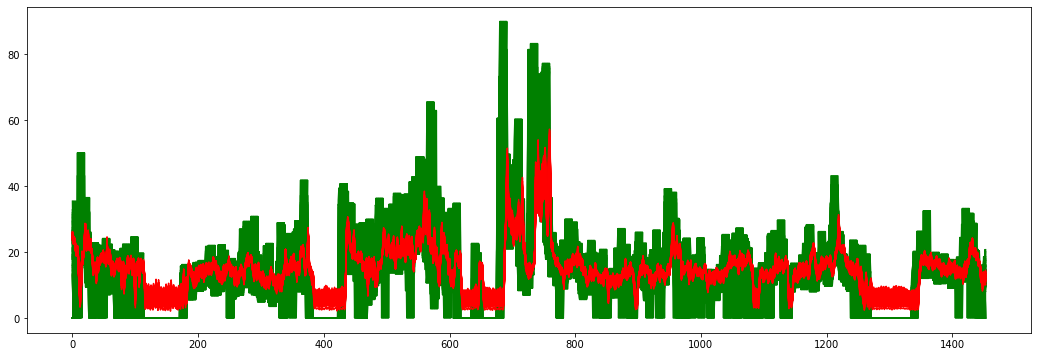

In [ ]:
plt.figure(figsize=(18,6))
plt.plot(ska_y_test, color='g')
plt.plot(ska_predict, color='r')
plt.show()

# Result

In [ ]:
def missing_data(file, predict):
    start_date = datetime.datetime(2019, 3, 18, 12)
    df = pd.read_csv(os.path.join(path, file))
    df['Missing date'] = pd.to_datetime(df['Missing date'])
    missing_list = df['Missing date'].to_list()
    missing_index = []
    for date in missing_list:
        if date.hour%6 == 0:
            missing_index.append(int((date-start_date).total_seconds()/3600/6))
    pred = []
    for i in range(predict.shape[0]):
        if not i in missing_index:
            pred.append(predict[i])
    pred = np.array(pred)
    return pred

In [ ]:
bkk_predict_ = missing_data('Bangkok.csv', bkk_predict)
cti_predict_ = missing_data('Chanthaburi.csv', cti_predict)
cmi_predict_ = missing_data('Chiang Mai.csv', cmi_predict)
kri_predict_ = missing_data('Kanchanaburi.csv', kri_predict)
kkn_predict_ = missing_data('Khon Kaen.csv', kkn_predict)
ska_predict_ = missing_data('Songkhla.csv', ska_predict)

In [ ]:
bkk_y_test_ = missing_data('Bangkok.csv', bkk_y_test)
cti_y_test_ = missing_data('Chanthaburi.csv', cti_y_test)
cmi_y_test_ = missing_data('Chiang Mai.csv', cmi_y_test)
kri_y_test_ = missing_data('Kanchanaburi.csv', kri_y_test)
kkn_y_test_ = missing_data('Khon Kaen.csv', kkn_y_test)
ska_y_test_ = missing_data('Songkhla.csv', ska_y_test)

In [ ]:
y_pred = np.array([])
y_pred = np.append(y_pred, cti_predict_)
y_pred = np.append(y_pred, cmi_predict_)
y_pred = np.append(y_pred, kri_predict_)
y_pred = np.append(y_pred, bkk_predict_)
y_pred = np.append(y_pred, kkn_predict_)
y_pred = np.append(y_pred, ska_predict_)
y_pred.shape

(481320,)

In [ ]:
y_true = np.array([])
y_true = np.append(y_true, cti_y_test_)
y_true = np.append(y_true, cmi_y_test_)
y_true = np.append(y_true, kri_y_test_)
y_true = np.append(y_true, bkk_y_test_)
y_true = np.append(y_true, kkn_y_test_)
y_true = np.append(y_true, ska_y_test_)
y_true.shape

(481320,)

In [ ]:
root_mean_square_error

{'Bangkok': 9.884646623842908,
 'Chanthaburi': 7.170019740015291,
 'Chiang Mai': 15.187432058028621,
 'Kanchanaburi': 12.330461548231861,
 'Khon Kaen': 12.314148536060873,
 'Songkhla': 8.172752075357574}

In [ ]:
miss_index = pd.read_csv(os.path.join(path, 'missing_index.csv'))
submission = pd.DataFrame(y_pred, columns=['Predicted'])
prediction_index = pd.read_csv(os.path.join(path, 'output_index.csv'))
submission['datetime index'] = prediction_index['predicted timestamp']
cond = submission['datetime index'].isin(miss_index['Missing date'])
submission.drop(submission[cond].index, inplace = True)
submission.reset_index(inplace=True)
submission['id'] = submission.index
submission = submission[['Predicted','id']]
submission.set_index('id',inplace=True)
submission

,Predicted
id,
0,30.158937
1,28.854824
2,27.977011
3,27.583923
4,27.419950
...,...
448549,12.981947
448550,13.261423
448551,13.320581


In [ ]:
pm25 = pd.DataFrame(y_true, columns=['PM2.5'])
pm25['datetime index'] = prediction_index['predicted timestamp']
cond = pm25['datetime index'].isin(miss_index['Missing date'])
pm25.drop(pm25[cond].index, inplace = True)
pm25.reset_index(inplace=True)
pm25['id'] = pm25.index
pm25 = pm25[['PM2.5','id']]
pm25.set_index('id',inplace=True)
pm25

,PM2.5
id,
0,33.5
1,33.5
2,35.2
3,32.9
4,30.5
...,...
448549,12.7
448550,11.5
448551,11.3


In [ ]:
mean_squared_error(submission['Predicted'], pm25['PM2.5'], squared=False)

10.400990372874473

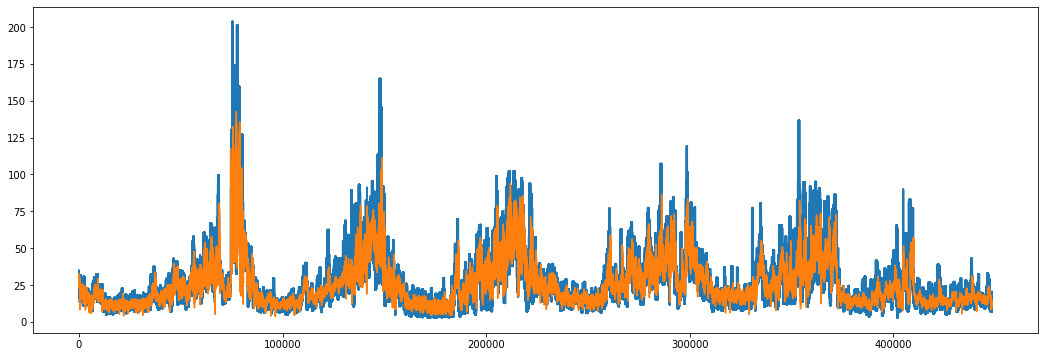

In [ ]:
plt.figure(figsize=(18,6))
plt.plot(pm25['PM2.5'])
plt.plot(submission['Predicted'])
plt.show()

In [ ]:
submission.to_csv(os.path.join(path, 'submission.csv'))